In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import re
import nltk
from collections import Counter

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the Flickr8k dataset (images and captions)
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.04G/1.04G [00:47<00:00, 25.1MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.5MB/s]


In [ ]:
import os
import shutil
import zipfile

# Unzip the dataset
with zipfile.ZipFile("flickr8k.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Create a 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Move the Images folder to the 'data' directory
if os.path.exists('Images'):
    shutil.move('Images', 'data/Images')

# Move the captions.txt file to the 'data' directory
if os.path.exists('captions.txt'):
    shutil.move('captions.txt', 'data/captions.txt')

print("Dataset downloaded and organized.")


Dataset downloaded and organized.


In [ ]:
# Load captions
captions_file = 'data/captions.txt'
df = pd.read_csv(captions_file, delimiter=',')
df = df.drop_duplicates().reset_index(drop=True)

In [ ]:
# Vocabulary class
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  #we reemove special characters
        return nltk.word_tokenize(text)

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4  #start after reserved tokens

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

In [ ]:
#time to build vocab
freq_threshold = 3
captions = df['caption'].tolist()
vocab = Vocabulary(freq_threshold)
vocab.build_vocabulary(captions)

In [ ]:
#testing it out
example_sentence = "A dog is playing in the garden."

#tokenize the sentence
tokenized_sentence = vocab.tokenizer_eng(example_sentence)
print("Tokenized Sentence:", tokenized_sentence)

#numericalize the tokenized sentence
numericalized_sentence = vocab.numericalize(example_sentence)
print("Numericalized Sentence:", numericalized_sentence)

#add <SOS> and <EOS> tokens
numericalized_sentence_with_tokens = [vocab.stoi["<SOS>"]] + numericalized_sentence + [vocab.stoi["<EOS>"]]
print("Numericalized Sentence with <SOS> and <EOS>:", numericalized_sentence_with_tokens)

#convert numericalized back to tokens
reconstructed_sentence = [vocab.itos[idx] for idx in numericalized_sentence_with_tokens]
print("Reconstructed Sentence:", reconstructed_sentence)


In [ ]:

class FlickrDataset(Dataset):
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.df = df
        self.transform = transform
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.df['caption'][idx]
        img_id = self.df['image'][idx]
        img_path = os.path.join(self.root_dir, img_id)
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),   #need to experiment with colorjitter transform.
])

dataset = FlickrDataset(root_dir='data/Images', df=df, transform=transform)

# DataLoader
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    imgs, captions = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    captions_padded = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.stoi["<PAD>"])
    return imgs, captions_padded

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)   #experimented batch sizes 32 and 64


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune(False)

    def forward(self, images):
        features = self.resnet(images)  #[batch_size, 2048, H, W]
        features = self.adaptive_pool(features)  #[batch_size, 2048, 14, 14]
        features = features.view(features.size(0), -1, features.size(1))  #[batch_size, num_pixels, 2048]
        return features

    def fine_tune(self, fine_tune=True):
        #fine-tuning only the last two layers of ResNet
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[-2:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  #[batch_size, num_pixels, attention_dim]
        att2 = self.decoder_att(decoder_hidden)  #[batch_size, attention_dim]
        att = self.full_att(torch.tanh(att1 + att2.unsqueeze(1))).squeeze(2)  #[batch_size, num_pixels]
        alpha = torch.softmax(att, dim=1)  #[batch_size, num_pixels]
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  #[batch_size, encoder_dim]
        return attention_weighted_encoding, alpha


In [ ]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048):
        super(DecoderWithAttention, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  #adaptive gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, captions, lengths):
        embeddings = self.embedding(captions)  #[batch_size, max_len, embed_dim]
        h, c = self.init_hidden_state(encoder_out)
        decode_lengths = (lengths - 1).tolist()
        predictions = torch.zeros(captions.size(0), max(decode_lengths), self.fc.out_features).to(encoder_out.device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, _ = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.lstm(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )
            predictions[:batch_size_t, t, :] = self.fc(h)

        return predictions


Using device: cuda


In [ ]:
from torch.optim import Adam
from torch.nn.utils.rnn import pack_padded_sequence

#initialize models
encoder = EncoderCNN().to(device)
decoder = DecoderWithAttention(attention_dim=256, embed_dim=256, decoder_dim=512, vocab_size=len(vocab)).to(device)

#define Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


In [ ]:

epochs = 10
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    for imgs, captions in data_loader:
        imgs, captions = imgs.to(device), captions.to(device)
        lengths = torch.tensor([len(cap) for cap in captions], dtype=torch.long).cpu()

        optimizer.zero_grad()
        features = encoder(imgs)  #extract features with the encoder (GPU)
        outputs = decoder(features, captions, lengths)  #decode captions (GPU)

        #targets and outputs for loss computation
        targets = pack_padded_sequence(captions[:, 1:], lengths - 1, batch_first=True).data
        outputs = pack_padded_sequence(outputs, lengths - 1, batch_first=True).data

        #loss computation ,backpropogation
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")


Epoch 1/10, Loss: 3.6685
Epoch 2/10, Loss: 3.0470
Epoch 3/10, Loss: 2.8090
Epoch 4/10, Loss: 2.6188
Epoch 5/10, Loss: 2.4511
Epoch 6/10, Loss: 2.2932
Epoch 7/10, Loss: 2.1454
Epoch 8/10, Loss: 2.0039
Epoch 9/10, Loss: 1.8761
Epoch 10/10, Loss: 1.7544


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(encoder, decoder, data_loader, vocab):
    encoder.eval()
    decoder.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for imgs, captions in data_loader:
            imgs = imgs.to(device)
            captions = captions.to(device)

            #extracting features and generate predictions
            features = encoder(imgs)
            outputs = decoder(features, captions, torch.tensor([len(c) for c in captions]).to(device))
            preds = outputs.argmax(2)

            for i in range(len(captions)):
                #reference (actual caption)
                ref = [
                    vocab.itos[idx] for idx in captions[i].cpu().numpy()
                    if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}
                ]
                references.append([ref])  #BLEU apparently expects a list of lists

                #hypothesis (generated caption)
                hyp = [
                    vocab.itos[idx] for idx in preds[i].cpu().numpy()
                    if idx not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}
                ]
                hypotheses.append(hyp)

    #compute BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score * 100:.2f}")

#runn evaluation on the test set
evaluate_bleu(encoder, decoder, data_loader, vocab)


BLEU Score: 18.42


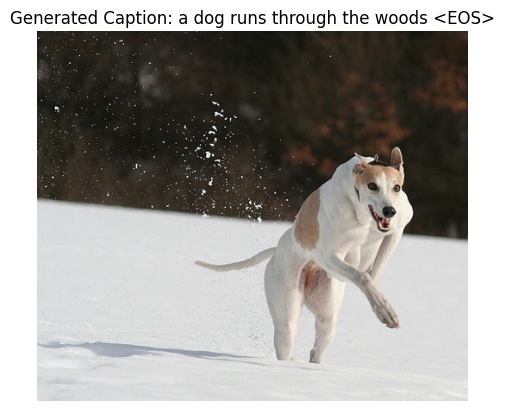

Actual Captions for 101654506_8eb26cfb60.jpg:
1: A brown and white dog is running through the snow .
2: A dog is running in the snow
3: A dog running through snow .
4: a white and brown dog is running through a snow covered field .
5: The white and brown dog is running over the surface of the snow .


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def check_generated_caption(image_path, encoder, decoder, vocab, transform, max_length=20):

    #load and preprocess image
    image = Image.open(image_path).convert("RGB")
    input_image = transform(image).unsqueeze(0).to(device)

    #caption generation
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        features = encoder(input_image)
        h, c = decoder.init_hidden_state(features)
        inputs = decoder.embedding(torch.tensor([vocab.stoi["<SOS>"]]).to(device))
        sampled_ids = []

        for _ in range(max_length):
            attention_weighted_encoding, _ = decoder.attention(features, h)
            gate = decoder.sigmoid(decoder.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = decoder.lstm(
                torch.cat([inputs, attention_weighted_encoding], dim=1), (h, c)
            )
            outputs = decoder.fc(h)
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())

            if vocab.itos[predicted.item()] == "<EOS>":
                break
            inputs = decoder.embedding(predicted)

    #coonvert sampled word IDs to words
    generated_caption = " ".join([vocab.itos[word_id] for word_id in sampled_ids])

    plt.imshow(image)
    plt.title(f"Generated Caption: {generated_caption}")
    plt.axis("off")
    plt.show()


    image_name = image_path.split('/')[-1]  # Extract image filename
    actual_captions = df[df['image'] == image_name]['caption'].tolist()
    print(f"Actual Captions for {image_name}:")
    for idx, caption in enumerate(actual_captions, 1):
        print(f"{idx}: {caption}")

#example
image_path = "/content/data/Images/101654506_8eb26cfb60.jpg"
check_generated_caption(image_path, encoder, decoder, vocab, transform)


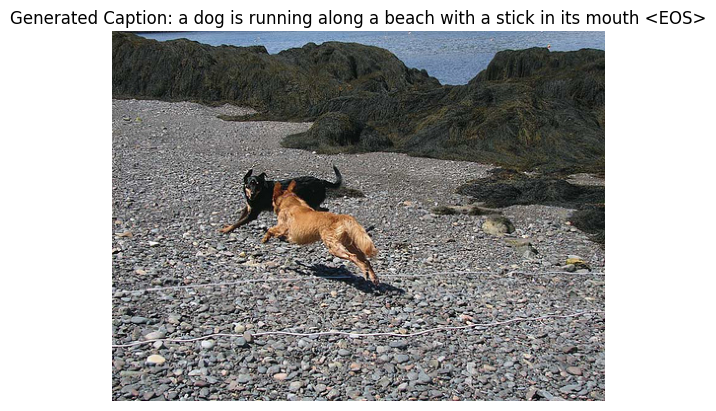

Actual Captions for 1056873310_49c665eb22.jpg:
1: A brown dog is running after a black dog on a rocky shore .
2: A brown dog is running after the black dog .
3: Two dogs playing on a beach .
4: Two dogs run across stones near a body of water .
5: Two dogs run towards each other on a rocky area with water in the background .


In [ ]:
image_path = "/content/data/Images/1056873310_49c665eb22.jpg"
check_generated_caption(image_path, encoder, decoder, vocab, transform)


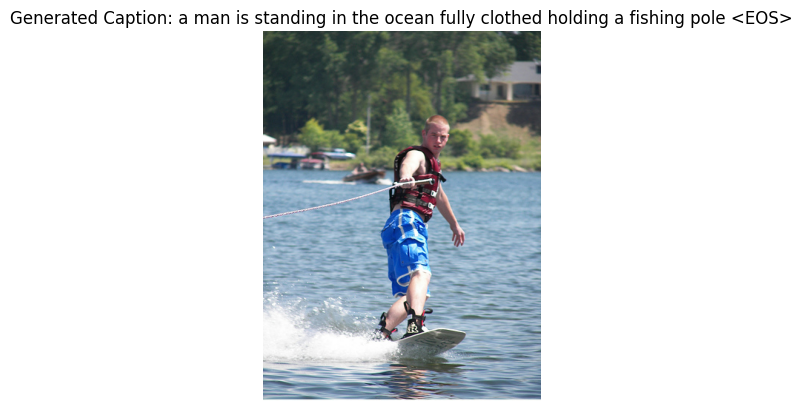

Actual Captions for 172092464_d9eb4f4f2f.jpg:
1: A guy waterskiing behind a boat .
2: a man wakeboards on a lake .
3: A young man is wakeboarding on a body of water .
4: Blond boy waterskiing .
5: The boy is wakeboarding on the lake .


In [ ]:
image_path = "/content/data/Images/172092464_d9eb4f4f2f.jpg"
check_generated_caption(image_path, encoder, decoder, vocab, transform)
